In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("LANGSMITH_API_KEY")

# AI Meeting Summary Generator

This Jupyter notebook implements a complex workflow for processing and summarizing meetings using a graph-based architecture. Here's how it works:

## Core Components

1. **Graph Structure**
- Uses `langgraph` to create a directed graph of processing nodes
- Each node performs a specific task in the meeting analysis pipeline
- State is passed between nodes and maintained throughout execution

2. **Key Processing Nodes**
- Speaker Detection: Identifies and tracks meeting participants
- Text Accumulation: Builds up meeting transcript
- Keyword Extraction: Identifies important technical terms and concepts
- Research: Investigates technical terms that need definition
- Summarization: Creates summaries of meeting segments
- Final Summary: Generates comprehensive meeting minutes

3. **LLM Integration**
- Uses multiple language models (Ollama and OpenAI)
- Different models for different tasks (small models for simple tasks, larger ones for complex analysis)
- Templates and prompts specific to each task

4. **State Management**
- Maintains speakers, keywords, research terms, summaries etc.
- Tracks accumulated text and intermediate processing results
- Handles meeting start/end conditions

## Workflow Sequence

1. Meeting starts with initialization
2. Processes each speaker contribution through the graph
3. Accumulates content until sufficient for summarization
4. Creates intermediate summaries with coaching feedback
5. Generates final summary with footnotes and references
6. Handles meeting end with cleanup and final output

## Key Features

- Modular design with separate components for each task
- Flexible LLM usage with configurable models
- Maintains meeting context throughout processing
- Handles research and verification of technical terms
- Produces structured output with summaries and references
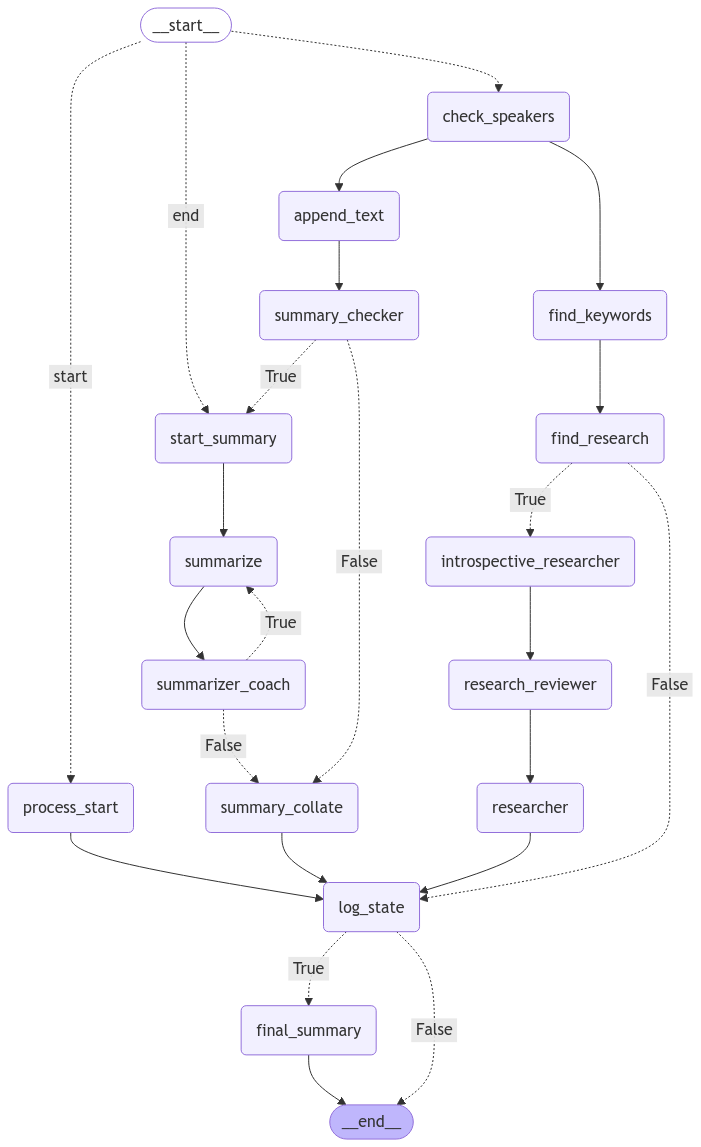

# Meeting Summarizer

This is a meeting summarization system that processes transcribed meetings and generates comprehensive summaries with key points, action items, and technical definitions.

## Usage Requirements

1. Input Format:
    - The system expects a JSON file containing meeting transcripts
    - Each record in the JSON should contain speaker name and text content
    - Records should be sequential in chronological order
    - if you don't have a JSON file, then there is a vttparser that can convert a vtt file to a JSON file

2. Output:
    - Results are logged to `app.log` in the local directory
    - Final summary includes:
      - Meeting overview
      - Key discussion points
      - Technical terms with definitions
      - Action items
      - Tags for key topics

3. Running the System:
    - The system will prompt for the JSON file path if not specified (so either edit the code or uncomement the input prompt)
    - Processing happens in real-time as it reads through the transcript
    - Progress and results are written to the log file
    - The final summary, and the footnotes, are displayed at the end of the meeting

## Example JSON Format:

In [ ]:
from typing import List
from langchain_core.prompts.chat import MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain.chains import ConversationChain
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage
from typing import Annotated
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.types import Command
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig, chain
from langchain_community.tools.tavily_search import TavilySearchResults

from pydantic import ValidationError
from typing import Any

import operator
from pydantic import BaseModel
import uuid
import json

import ast

Utility methods to enable switching easily between GPT and Ollama

In [ ]:
models = {
    "ollama": {"small": "llama3.2:1b", "regular": "llama3.2:latest", "big": "llama3.3:latest"},
    "openai": {"small": "gpt-4o-mini", "regular": "gpt-4o", "big": "o1"},
    "deepseek": {"small": "deepseek-r1:1.5b", "regular": "deepseek-r1:latest", "big": "deepseek-r1:14b"},
}
model_type = "ollama"
if model_type == "ollama":
    model_name = "llama3.2:latest"
    small_model_name = "llama3.2:1b"
    big_model_name = "llama3.1:latest"
else:
    model_name = "gpt-4o"
    small_model_name = "gpt-4mini"
    big_model_name = "o1"

In [ ]:
current_llm = None

llms = {
    "ollama": {"small": None, "regular": None, "big": None},
    "openai": {"small": None, "regular": None, "big": None},
    "deepseek": {"small": None, "regular": None, "big": None},
    "models": {"ollama": ChatOllama, "openai": ChatOpenAI, "deepseek": ChatOllama},
}

def get_llm(type="ollama", size="regular"):
    # if the current_llm is None, create a new one and assign it to that global variable
    # then return current_llm
    global llms
    #if llms["type"][size] is None:
    #    llms["type"][size] = llms["models"][type](model=models[type][size], temperature=0)  
    #return llms["type"][size]
    return llms["models"][type](model=models[type][size], temperature=0)

def get_tool_llm(tool_class, type="ollama", size="regular"):
    llm = get_llm(type, size)
    llm_with_tool = llm.bind_tools([tool_class])

    return llm_with_tool

def get_llm_with_tools(tools, type="ollama", size="regular"):
    llm = get_llm(type, size)
    llm_with_tools = llm.bind_tools(tools)

    return llm_with_tools

Set up the logging

In [ ]:
import logging
import sys

def configure_logging(log_to_file: bool = False, logfile: str = "app.log", level: int = logging.DEBUG): 
    logger = logging.getLogger(__name__)
    logger.setLevel(level)
    formatter = logging.Formatter(
        fmt="%(asctime)s - %(levelname)s - [%(module)s.%(funcName)s] - %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )

    # Clear existing handlers
    if logger.hasHandlers():
        logger.handlers.clear()

    if log_to_file:
        file_handler = logging.FileHandler(logfile)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    else:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

    return logger

logger = configure_logging(True, level=logging.INFO)
logger.info("Logging initialized successfully.")

In [ ]:
def dump_graph(snapshot):
    for key in snapshot.values.keys():
        logger.info(f"Key: {key}")
        if key != "messages":
            for value in snapshot.values[key]:
                logger.info(f"{key}: {value}")
        else:
            logger.info(f"Messages: {len(snapshot.values[key])}")


In [ ]:

def preprocess_input(input_string: str) -> str:
    """
    Preprocess the input string to handle any syntax issues.

    Parameters:
        input_string (str): The raw input string.

    Returns:
        str: A cleaned-up string ready for evaluation.
    """
    # Escape double quotes inside the string while keeping JSON format intact
    input_string = input_string.strip()
    input_string = input_string.replace('""', '"')
    input_string = input_string.replace("\\'s", "'s")  # Correct escaped single quotes
    # find the position of the last close bracket "]"
    last_close_bracket = input_string.rfind("]")
    # if the last close bracket is not the last character trim to that position (as long as it was found)
    if last_close_bracket != -1:
        input_string = input_string[:last_close_bracket + 1]
        # if the second last character is a period, remove it
        if input_string[-2] == ".":
            input_string = input_string[:-2] + input_string[-1]

    return input_string

    
def string_to_array(input_string):
    """
    Convert the given string variable `input_string` into an array of strings.

    Parameters:
        input_string (str): A string representation of a Python list.

    Returns:
        list: A list of strings.
    """
    import ast

    try:
        # Use ast.literal_eval to safely evaluate the string as a Python list
        result = ast.literal_eval(input_string)

        # Ensure it's a list of strings
        if isinstance(result, list) and all(isinstance(item, str) for item in result):
            return result
        else:
            raise ValueError("The input string does not represent a list of strings.")
    except Exception as e:
        raise ValueError(f"Invalid input format: {e}")
   

Getting into the actual work after the configuration is done and the helpers are defined

In [ ]:
def merge_lists(left: List[str], right: List[str]) -> List[str]:
    """
    Merge two lists of strings into a single list.

    Parameters:
        left (List[str]): The first list of strings.
        right (List[str]): The second list of strings.

    Returns:
        List[str]: A single list containing all unique strings from both input lists.
    """
    logger.debug(f"merge_lists left: {left}, right: {right}")
    # Combine the two lists and convert to a set to remove duplicates
    return list(set(left + right))

def add_unique_items(left: List[str], right: List[str]) -> List[str]:
    logger.debug(f"add_items left: {left}, right:{right}")
    # logger.debug the classes of the two items
    logger.debug(f"left: {type(left)}, right: {type(right)}")
    # logger.debug the type of the items in the list to the left
    if len(left) > 0:
        logger.debug(f"left[0]: {type(left[0])}")

    # return a single list of the unique sorted speakers from both lists
    return sorted(list(set(left + right)))

def add_unique_keywords(left: List[str], right: List[str]) -> List[str]:
    return add_unique_items(left, right)

def add_unique_speakers(left: List[str], right: List[str]) -> List[str]:
    return add_unique_items(left, right)

def add_unique_research_terms(left: List[str], right: List[str]) -> List[str]:
    return add_unique_items(left, right)

def add_unique_researched_terms(left: List, right: List) -> List:
    # the list is of pairs of strings, the first is the term, the second is the definition, including sources
    # uniqueness is defined only based on the first field, where the right side is the most recent
    # in the result we want the full pair, but only the most recent definition returned as a list
    # the result should be sorted by the term
    # the result should be unique by the term
    # the result should be the most recent definition
    # first off we need to create a unique set of the terms in the two lists, the term is always the first of the pair

    # convert the lists of pairs into dictionaries of term: definition
    left_dict = dict(left)
    right_dict = dict(right)

    # create a set of the unique terms
    left_dict.update(right_dict)
    # create a list of the sorted terms
    result = sorted(left_dict.items())

    return result

def add_unique_tags(left: List[str], right: List[str]) -> List[str]:
    return add_unique_items(left, right)

# create a method which receives two strings, and returns the longest of the two
def get_longest(left: str, right: str) -> str:
    return max(left, right, key=len)

# create a method which receives two strings, right side one
def get_right_side(left: str, right: str) -> str:
    logger.debug(f"get_right_side left: {left}, right: {right}")
    return right

def choose_right(left:Any, right:Any) -> Any:
    logger.debug(f"choose_right left: {left}, right: {right}")
    return right

def choose_right_list(left:List[int], right:List[int]) -> List[int]:
    logger.debug(f"choose_right_list left: {left}, right: {right}")
    return right

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    keywords: Annotated[list, add_unique_keywords]
    research_terms: Annotated[list, add_unique_research_terms]
    candidate_researched_terms: Annotated[list, choose_right_list]
    researched_terms: Annotated[list, add_unique_researched_terms]
    tags: Annotated[list, add_unique_tags]
    full_text: Annotated[str, get_longest]
    run_summary: Annotated[bool, choose_right]
    additional_text: Annotated[str, get_right_side]
    summary: Annotated[str, get_right_side]
    approved_summaries: Annotated[list, merge_lists]
    full_text_summary: Annotated[str, get_right_side]
    suggest_summary: Annotated[str, get_right_side]
    coaching: Annotated[list, choose_right_list]
    coaching_events: Annotated[int, choose_right]
    speakers: Annotated[list, add_unique_speakers]
    minutes: str
    footnotes: Annotated[str, get_right_side]
    meeting_title: Annotated[str, get_right_side]
    meeting_abstract: Annotated[str, get_right_side]


# method that returns any research terms that are not in the researched terms list
def get_new_research_terms(state: State) -> List[str]:
    return_value = []
    # first check if there are any research terms, if there aren't return an empty list
    if "research_terms" in state and len(state["research_terms"]) != 0:
        if "researched_terms" in state and len(state["researched_terms"]) != 0:
            # create a list of just the terms from the research_terms which is an array of pairs, first item being the term
            already_researched = [term for term, definition in state["researched_terms"]]
            # if there are research terms and there are researched terms, then return the difference between the two
            return_value = [term for term in state["research_terms"] if term not in already_researched]
        else:
            logger.info("No researched terms found in the state")
            return_value = state["research_terms"]
    else:
        logger.info("No research terms found in the state")

    
    logger.info(f"get_new_research_terms: {return_value}")

    return return_value

In [ ]:
def log_state_info(state: State) -> State:

    # Log the number of messages
    num_messages = len(state["messages"])
    logger.info(f"Number of messages: {num_messages}")

    # Log each message text
    for i, message in enumerate(state["messages"]):
        logger.debug(f"Message {i+1}: {message}")

    # Check and log the number of speakers
    if "speakers" in state and state["speakers"]:
        num_speakers = len(state["speakers"])
        logger.info(f"Number of speakers: {num_speakers}")
        for speaker in state["speakers"]:
            logger.debug(f"Speaker: {speaker}")
    else:
        logger.info("No speakers found")

    # Check and log the number of keywords
    if "keywords" in state and state["keywords"]:
        num_keywords = len(state["keywords"])
        logger.info(f"Number of keywords: {num_keywords}")
        for keyword in state["keywords"]:
            logger.debug(f"Keyword: {keyword}")
    else:
        logger.info("No keywords found")

    # if there is full_text, log it
    if "full_text" in state and state["full_text"]:
        logger.debug(f"Full text: {state['full_text']}")
    else:
        logger.info("No full text found")

    # log the additional text
    if "additional_text" in state and state["additional_text"]:
        logger.debug(f"Additional text: {state['additional_text']}")
    else:
        logger.info("No additional text found")

    # log the summary
    if "summary" in state and state["summary"]:
        logger.debug(f"Summary: {state['summary']}")
    else:
        logger.info("No summary found")

    # log the approved summaries
    if "approved_summaries" in state and state["approved_summaries"]:
        logger.info(f"Approved summaries: {len(state['approved_summaries'])}")
        logger.debug(f"Approved summaries: {state['approved_summaries']}")
    else:
        logger.info("No approved summaries found")


    return state

In [ ]:


def extract_tool_call(response: Any, tool_class: BaseModel) -> BaseModel:
    logger.debug(f"Response: {response}. Class: {tool_class}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            if tool_call["name"] == tool_class.__name__:
                args = tool_call['args']
                logger.debug(f"Class: {tool_class} from Args: {args}")
                converted_args = {}
                
                for field_name, field_type in tool_class.__annotations__.items():
                    logger.debug(f"Field name: {field_name}, field type: {field_type}")
                    if field_name in args:
                        value = args[field_name]
                        if field_type is List[str] and isinstance(value, str):
                            converted_args[field_name] = convert_string_to_array(value, field_name)
                                    
                        elif field_type is List[str] and isinstance(value, list):
                            converted_args[field_name] = value
                        elif isinstance(value, field_type):
                            converted_args[field_name] = value
                        elif field_type is bool:
                            if isinstance(value, str):
                                if value.lower() in ["true", "yes"]:
                                    converted_args[field_name] = True
                                elif value.lower() in ["false","no"]:
                                    converted_args[field_name] = False
                                else:
                                    logger.error(f"Cannot convert {value} to boolean for {field_name}")
                                    converted_args[field_name] = False
                                    #raise ValidationError(f"Cannot convert {value} to boolean for {field_name}")
                            else:
                                logger.error(f"Field {field_name} is not of type {field_type}, is {type(value)}:{value}")
                                converted_args[field_name] = False

                        else:
                            logger.error(f"Field {field_name} is not of type {field_type}, is {type(value)}:{value}")
                            #raise ValidationError(f"Field {field_name} is not of type {field_type}")
                    else:
                        logger.error(f"Missing field {field_name} in args")

                try:
                    tool_instance = tool_class(**converted_args)
                except ValidationError as ve:
                    logger.error(f"Validation error: {ve}, args: {args}")
                    tool_instance = None

                logger.debug(f"Tool instance: {tool_instance}")
                return tool_instance
    return None

def convert_string_to_array(value, field_name):
    try:
        # Preprocess the input string
        input_string = preprocess_input(value)

        # use the string to array function
        returnValue = string_to_array(input_string)
    except ValueError as ve:
        logger.error(f"Error converting string to array: {ve}")

        try:
            # replace all newline characters in the string with spaces
            input_string = input_string.replace("\n", " ")                                    
            loaded_value = json.loads(input_string)
            if isinstance(loaded_value, list):
                returnValue = loaded_value
            else:
                logger.error(f"Field {field_name} is not of a list")
                returnValue = [input_string]
        except json.JSONDecodeError:
            logger.error(f"field name: {field_name} is not a JSON string it is: {value}")
            returnValue = [input_string]
                                        
    return returnValue

In [ ]:
# get the most recent human message as a JSON object
def get_most_recent_human_message_as_JSON(state: State) -> HumanMessage:
    for message in reversed(state["messages"]):
        if isinstance(message, HumanMessage):
            return json.loads(message.content)    
    return None

def get_most_recent_human_message(state: State) -> Any:
    for message in reversed(state["messages"]):
        if isinstance(message, HumanMessage):
            return message
        
    return None

Code that handles the initailization of the graph for a specific meeting

In [ ]:
def check_start_node(state: State) -> bool:
    logger.info("Checking Start")
    # The very first message we receive must be the initialization, this might not
    # contain a title or abstract, but it will contain the order to start the meeting
    if len(state["messages"]) == 1:
        first_message = state["messages"][0]
        if isinstance(first_message, AIMessage):
            # need to load the document as a JSON
            first_message = json.loads(first_message.content)
            # check if the first message is the start message
            if "start" in first_message:
                logger.info("Found the start message")
                return True

    return False

def process_start_node(state: State) -> State:
    logger.info("Processing Start")
    # the start message is the first message, it should contain the order to start the meeting
    # it may not contain a title or abstract, but if it does we need to store them in the State
    first_message = state["messages"][0]
    return_value = State()
    if isinstance(first_message, AIMessage):
        # need to load the document as a JSON
        first_message = json.loads(first_message.content)
        # check if the first message is the start message
        if "start" in first_message:
            logger.info("Found the start message, checking for title and abstract")
            # if it is, then we need to check if there is a title and abstract
            if "title" in first_message:
                return_value["meeting_title"] = first_message["title"]
            if "abstract" in first_message:
                return_value["meeting_abstract"] = first_message["abstract"]

            return return_value
        
    return None



In [ ]:
# create an AI message to start the meeting, it should have a "start" value, and the provided title and abstract
# if they are not None, it should return a new config string
def start_meeting(title: str, abstract: str) -> str:
    """
    Send the initial request to the graph signifying the start of the meeting.
    
    Args:
        title (str): The title of the meeting.
        abstract (str): The abstract of the meeting.
        
    Returns:
        the new config object for the meeting
    """
    # Send an AI message indicating start of meeting
    start_message = AIMessage(content=json.dumps({"start": True, "title": title, "abstract": abstract}))
    logger.info(f"Starting meeting")
    new_config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    # Execute the graph one final time with the end message
    for output in graph.stream(
        {"messages": [start_message]}, 
        config=new_config,
        stream_mode="updates"
    ):
        logger.debug(f"Start output: {output}")

    return new_config

    

In [ ]:
# Conditional that checks whether or not it is the start or end of the meeting.
# returns "start" if it is the start of the meeting, "end" if it is the end of the meeting, and None otherwise
def check_start_or_end(state: State) -> str:
    logger.info("Checking Start or End")
    '''
    Check if the current state is the start or end of the meeting.
    Args:
        state (State): The current state of the conversation.
    Returns:
        str: "start" if the state is the start of the meeting, "end" if it is the end of the meeting, and None otherwise.
    '''
    # Check if the state is the start of the meeting
    if check_start_node(state):
        return "start"
    # Check if the state is the end of the meeting
    if check_end_node(state):
        return "end"
    # Otherwise return None
    return None


Method that checks for a new speaker and ensures it is in the state

In [ ]:
def speaker_check(state:State) -> State:
    logger.info("Checking for speakers")

    if "speakers" not in state:
        state["speakers"] = []
        logger.debug("Speakers initialized")
        
    # get the most recent human message
    human_message = get_most_recent_human_message_as_JSON(state)

    # check for the speaker in the last message
    if "speaker" in human_message:
        speaker = human_message["speaker"]
        if speaker not in state["speakers"]:
            state["speakers"].append(speaker)
            logger.info(f"Added speaker {speaker}")
    else:
        logger.info(f"No speaker found in last message {state['messages'][-1]}")

    logger.log(logging.DEBUG, f"Speakers: {state['speakers']}")
    return state

Method that turns the human messages into flat text so it can be passed in a more compressed form to the model, in future this will also be used to indicate additional
text that should be added to the overall minutes.

In [ ]:
def append_text(state: State) -> State:
    logger.info("Building full text")

    # check if the full text already exists
    if "full_text" not in state:
        state["full_text"] = ""
        logger.debug("Full text initialized")


    # for the most recent HumanMessage in the list
    human_message = get_most_recent_human_message_as_JSON(state)

    # append the text to both the full_text and additional_text, on a newline
    # if there is already something in those variables
    if human_message:
        if "text" in human_message:
            text = human_message["text"]
            speaker = human_message["speaker"]
            # Can be updated in future to anonymize the speaker into A, B, C, etc.
            state["full_text"] += speaker + ": " + text + "\n"
            if "additional_text" not in state:
                state["additional_text"] = ""
            state["additional_text"] += speaker + ": " + text + "\n"
        else:
            logger.info(f"No text found in message {human_message}")

    logger.debug(f"Full text: {state['full_text']}")

    return state

Method that takes a string value and either returns it if it is already an object, or uses JSON to convert it to an object, most normally an array

In [ ]:
def ensure_json_object(obj):
    if isinstance(obj, str):
        if obj.strip() == "":
            return {}
        else:
            return json.loads(obj)
    return obj

This part of the LLM looks for keywords in the text and nothing else, it then aims to add those keywords to a list and ensure the list is unique

In [ ]:
keyword_examples = [
    "agentic",
    "AI",
    "AI ethics",
    "AI governance",
    "Agent AI",
    "Agentic Integration", 
    "data strategy",
    "data pipelines",
    "data architecture",
    "data governance",
    "data ethics",
    "big data",
    "real-time data",
    "data integration",
    "data-driven decision-making",
    "data insights",
    "data scalability",
    "autonomous agents",
    "decision-making AI",
    "goal-oriented AI",
    "self-directed AI",
    "adaptive intelligence",
    "agent capabilities",
    "multi-agent systems",
    "context-aware AI",
    "agent control mechanisms",
    "proactive AI",
    "intelligent agents",
    "virtual agents",
    "AI-powered assistants",
    "AI collaboration tools",
    "task automation",
    "conversational agents",
    "agent learning",
    "interactive AI agents",
    "agent-based modeling",
    "content generation",
    "AI creativity",
    "text-to-image",
    "AI storytelling",
    "generative models",
    "diffusion models",
    "GANs",
    "creative AI tools",
    "synthetic data",
    "AI-generated art",
    "AI writing assistants",
    "large language models",
    "transformer models",
    "fine-tuning",
    "prompt engineering",
    "language understanding",
    "contextual language models",
    "LLM applications",
    "multilingual models",
    "zero-shot learning",
    "model scalability",
    "AI strategy",
    "digital transformation",
    "AI ROI",
    "automation in business",
    "AI-driven innovation",
    "AI adoption",
    "AI in workflows",
    "scaling AI",
    "AI in customer experience",
    "ethical AI implementation",
    "AI in competitive advantage",
    "future of work"
]



In [ ]:
keyword_finder_message = """You are a social media expert and are given the task of analyzing statements within a meeting and identifying when
the conversation hits popular keywords in a space. You are not to imagine any content, and only use what you are provided with, you will be provided with
a list of example keywords that you might find, but you should not limit yourself to these examples. The examples themselves are not
to be used directly, but only as a reference to the sort of content you should be looking for in the conversation to identify as keywords.
"""

keyword_template = ChatPromptTemplate([("system", keyword_finder_message),
                                       # placeholder that will be sent the text of the conversation to understand and identify keywords within
                                       MessagesPlaceholder(variable_name="conversation", message_type="human"),
                                       MessagesPlaceholder(variable_name="example_keywords", message_type="ai", optional=True),])


class Keywords(BaseModel):
    """The list of keywords that the model should keep track of"""
    keywords: List[str]

In [ ]:
keyword_llm = keyword_template | get_tool_llm(Keywords, type="ollama", size="small")

In [ ]:
def keyword_node(state: State) -> State:
    logger.info("Finding keywords")
    returnState = State()

    # could be modified to just use the message directly rather than the JSON load and dump
    message = get_most_recent_human_message(state)

    keywords = AIMessage(content=json.dumps(keyword_examples))

    logger.debug(f"Finding Keywords in: {message}")

    response = keyword_llm.invoke({"conversation": [message], "example_keywords": [keywords]})
    logger.debug(f"Keywords response: {response}")

    keywords_found = extract_tool_call(response, Keywords)
    if keywords_found:
        returnState["keywords"] = keywords_found.keywords
        logger.debug(f"Keywords: {state['keywords']}")
    else:
        logger.info("No keywords found in response")
    
    return returnState

A judgemental method that identifies terms that would be useful to do further research on

In [ ]:
research_judgement_system_message = """You are a technical research assistant who has the job of identifying technical terms or topics within a conversation
that would justify additional research to better explain them to a technical audience, you are not to imagine any content, and only use what you are provided with. 
You will be provided with a statement which most likely will contain no terms for research.  You should only identify a term
for research where an less seasoned expert in the field might be unsure of its meaning and would need to search the internet to understand it.
Good terms are proper nouns, acronyms, or technical terms that are not in common usage.  You should never select standard English words or phrases, and numbers are never required to
be researched.
"""

research_judge_template = ChatPromptTemplate([("system", research_judgement_system_message),
                                       # placeholder that will be sent the text of the conversation to understand and identify keywords within
                                       MessagesPlaceholder(variable_name="conversation", message_type="human", optional=False),])

class ResearchJudge(BaseModel):
    """The list terms to be researched"""
    research_terms: List[str]


In [ ]:
research_judge_llm = research_judge_template | get_tool_llm(ResearchJudge, type="ollama", size="regular")

In [ ]:
def research_judge_node(state: State) -> State:
    logger.info("Judging for research")
    returnState = State()

    # could be modified to just use the message directly rather than the JSON load and dump
    message = get_most_recent_human_message(state)
    logger.info(f"Checking for research in: {message}")
    response = research_judge_llm.invoke({"conversation": [message]})
    logger.info(f"Research judge response: {response}")

    research_terms_found = extract_tool_call(response, ResearchJudge)
    if research_terms_found:
        # loop through the returns and remove any item that is just a number
        returnState["research_terms"] = [term for term in research_terms_found.research_terms if not term.strip().isdigit()]
    else:
        logger.info("No research terms found in response")
    
    return returnState

This researcher uses only internal data to do the research, it is not a web scraper, the goal is then for a reviewer to look at the data and decide if it is useful or not, and whether an internet search is required.

In [ ]:
introspective_researcher_message = """You are a technical expert who is being asked to give definitions of terms that are not commonly known, but which are
important to the field. You are not to imagine any content, but are to use the information you have at your disposal to see if you can provide
a reasonable definition.  It is perfectly acceptable to not be able to have a definition, particularly if it is refering
to current events, is a new term in a technical field or refers to a specific person, event or technology.  If you are not certain
of your definition you should not return a definition, you must be confident that your definition is good and should never imagine a
definition, you should also be able to cite the sources for your definition.  You are not to imagine any content and only use what you are provided with.
You should return the definition in a dictionary format of term: definition, where the term is the term you are defining and the definition is the definition you have found.  You should not
provide any commentary or additional information, just the term and the definition with its sources listed. 
If you are not able to find a good definition just return "term: No definition found"
"""

introspective_researcher_template = ChatPromptTemplate([("system", introspective_researcher_message),
                                       # placeholder that will be sent the text of the conversation to understand and identify keywords within
                                       MessagesPlaceholder(variable_name="term", message_type="human", optional=False),])

introspective_researcher_llm = introspective_researcher_template | get_llm(type="ollama", size="regular")

def introspective_researcher_node(state: State) -> State:
    logger.info("Introspective Researcher")
    returnState = State()

    terms_to_research = get_new_research_terms(state)
    if terms_to_research:
        returnState["candidate_researched_terms"] = []
    for term in terms_to_research:
    # could be modified to just use the message directly rather than the JSON load and dump
        message = HumanMessage(content=f"Define:{term}")
        logger.info(f"Checking for definitions in: {message}")
        response = introspective_researcher_llm.invoke({"term": [message]})
        logger.info(f"Introspective Researcher response: {response}")

        definition_found = response.content
        logger.info(f"Definition found: {definition_found}")
        if definition_found and "no definition found" not in definition_found.lower():
            returnState["candidate_researched_terms"].append((term, definition_found)) 
        else:
            logger.info("No good definitions found in response")
    
    return returnState    


This is a critical judge of definitions, which determine whether or not a definition is good enough to be used, and if so adds it to the researched terms (which means it won't then be researched again)

In [ ]:
research_reviewer_message = """You are a technical expert who is being asked to critically review the definition of a particular term to determine if it is acceptable. You are not to imagine any content, but are to use the information you have at your disposal to see if you can provide
a reasonable review of the research that has been done and whether the definition provided is of high quality and makes sense.  You are also famed for the terse nature of your reviews, and are not to provide a definition yourself, you are
just judging if it is acceptable or not.  Dictionary definitions that cite sources are acceptable, and generally definitions with sources
should be considered acceptable, with non-sourced examples you should more deeply consider whether the definition is acceptable or not. You are not worried about format, simply
whether the definition correctly explains the term. You reply with only a single word, "Acceptable" or "Unacceptable" and nothing else, you provide no additional feedback
no additional context, just simply the one word reply.
"""

class ResearchReviewer(BaseModel):
    """The list terms to be researched"""
    acceptable: str

research_reviewer_template = ChatPromptTemplate([("system", research_reviewer_message),
                                       # placeholder that will be sent the text of the conversation to understand and identify keywords within
                                       MessagesPlaceholder(variable_name="term_and_definition", message_type="human", optional=False),])

research_reviewer_llm = research_reviewer_template | get_tool_llm(ResearchReviewer, type="ollama", size="regular")

def research_reviewer_node(state: State) -> State:
    logger.info("Research Reviewer")
    returnState = State()

    terms_to_research = state["candidate_researched_terms"]
    if terms_to_research:
        # make sure we have an empty list so we don't keep hitting the same terms
        returnState["candidate_researched_terms"] = []
        returnState["researched_terms"] = []
            
        for term, definition in terms_to_research:
            message = HumanMessage(content=f"Term:{term}\nDefinition:{definition}")
            logger.info(f"Checking if definition is acceptable: {message}")
            response = research_reviewer_llm.invoke({"term_and_definition": [message]})
            logger.debug(f"Researche Reviewer response: {response}")

            definition_found = extract_tool_call(response, ResearchReviewer)
            logger.info(f"Review found: {definition_found}")
            if definition_found and not "unacceptable" in definition_found.acceptable.lower():
                returnState["researched_terms"].append((term, definition)) 
            else:
                logger.info(f"Definition of '{term}' as '{definition}' is Not acceptable")
        
    return returnState    

This is the researcher, this goes to the internet, it never seems to look interally first, so we need to split the work.

In [ ]:

# This is the researcher, it looks internally first but has the option to go to the internet for information, it is only activated if there is a new term that has not been defined before
researcher_system_message = """You are a researcher, you are given a term that needs additional research, your job is to do some research,
this could be information you have internally, or could be information that you find by searching on the internet, it is your decision
whether or not you need to search the internet or have enough information already.  Your job is to create a concise definition
of the term and to clearly cite your sources so others can then verify and follow up, you are not to add any superflous information, just simply a useful and complete definition of the term.  You must never imagine a term to research and only research those terms
which you are given.  You should return the result in the form of term, definition and clearly cite the sources used. If you 
cannot find a definition, you should return an empty string and neither make up a definition or ask for additional content, it is
perfectly acceptable to not find a definition, it is not acceptable to be unable to find a definition and either make it up
or ask for additional content.
"""



researcher_template = ChatPromptTemplate([("system", researcher_system_message),
                                       # placeholder that will be sent the text of the conversation to understand and identify keywords within
                                       MessagesPlaceholder(variable_name="term", message_type="ai", optional=True),
                                       MessagesPlaceholder(variable_name="placeholder", message_type="ai", optional=True),])

class ResearchResults(BaseModel):
    """The research results"""
    term: str
    definition: str

tavily_tool = TavilySearchResults(max_results=3, 
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False,)


In [ ]:
researcher_llm = researcher_template | get_llm_with_tools([tavily_tool], type="ollama", size="regular")

@chain
def researcher_tool_chain(term: str, config: RunnableConfig):
    input_ = HumanMessage(content=term)
    ai_msg = researcher_llm.invoke({"term": [input_]}, config=config)
    tool_msgs = tavily_tool.batch(ai_msg.tool_calls, config=config)
    return researcher_llm.invoke({"term": [input_], "placeholder": [ai_msg, *tool_msgs]}, config=config)


There are two nodes here, the first determines whether or not there are new research terms and the second then does the actual research, this could
be done in a single node, but it is split for clarity

In [ ]:
def needs_research(state: State) -> bool:
    new_terms = get_new_research_terms(state)
    logger.info(f"Checking for new research terms : {new_terms != []}")
    return new_terms != []

In [ ]:
def research_term(term: str) -> str:
    logger.info(f"Internet Researching term: {term}")

    message = f"Define: {term}"
    response = researcher_tool_chain.invoke(message)
    logger.info(f"Internet response: {response}")

    # this doesn't put things into the tool, it is just in the content, if it exists.
    definition = response.content
    # definition = "Just a DUMMY definition"

    return definition 

def researcher_node(state: State) -> State:
    logger.info("Judging for research")
    returnState = State(researched_terms=[])
    terms_to_research = get_new_research_terms(state)
    for term in terms_to_research:
        definition = research_term(term)
        if definition:
            returnState["researched_terms"].append((term, definition))
        else:
            logger.info(f"No definition found for term: {term}")
    
    return returnState

Now into the part that actually does the summarization of the meeting itself.  Going to run this as a parallel execution (because why not) and with a model of an initial summary and then a reviewer in a loop.  This is also where the check will be added in future to check if there is actually enough
to write summaries on, and to track blocks of text to do those summaries on

In [ ]:
summarizer_system_message = """you are a technical writer in the field of computer science, AI and technology, and an expert executive assistant.
You are listening into a meeting on a technical topic and your job is to write the meeting summary, your role is just to summarize the keypoints and actions from the meeting.
You are not given the whole meeting transcript, but are given individual sections of the meeting to summarize.  You must never imagine or make up content, you must only summarize what you are provided.
The meeting is held under Chatam House Rules so you are interested in only what is said, not who said it.  You should concentrate instead on the technical content, business impacts, people impacts and other key elements. You might be provided with previous
summaries and as well as coaching to help you, you should listen to the coaching and act upon it.
You must never imagine or make up content, you must only summarize what you are provided.
"""

summarizer_template = ChatPromptTemplate([("system", summarizer_system_message),
                                       # placeholder that will be sent the text of the conversation
                                       MessagesPlaceholder(variable_name="meeting_text", message_type="ai", optional=False),
                                       MessagesPlaceholder(variable_name="summary", message_type="ai", optional=True),
                                       MessagesPlaceholder(variable_name="coaching", message_type="ai", optional=True),])

class Summary(BaseModel):
    """The summary"""
    summary: str

In [ ]:
summarizer_llm = summarizer_template | get_tool_llm(Summary)

In [ ]:
def summarizer_node(state: State) -> State:
    logger.info("Creating summary")
    returnState = state

    # we need to check if there is full_text, summary and coaching in the state
    if "full_text" not in state:
        # we can't create a summary without text, so we need to return a state with the full_text initialized
        # and summary initialized to an empty string
        return returnState
    
    # now check if there is an existing, non-blank, summary in the state
    if "summary" not in state:
        returnState["summary"] = ""
        logger.info("Summary initialized")
        summary = None
    else:
        summary = state["summary"]
        logger.debug(f"Summary: {summary}")

    # now check if there is existing coaching
    if "coaching" not in state:
        coaching = None
    else:
        coaching = state["coaching"]
        logger.debug(f"Coaching: {coaching}")

    # create a human message with the additional_text
    message = HumanMessage(content=json.dumps({"text": state["additional_text"]}))
    # create a human message with the summary if it isn't None
    if summary:
        summary = HumanMessage(content=json.dumps({"summary": summary}))
    # create a human message with the coaching if it isn't None
    if coaching:
        coaching = HumanMessage(content=json.dumps({"coaching": coaching}))

    # call the summarizer_llm with the message, but only the summary and coaching if they are not None
    if summary:
        if coaching:
            response = summarizer_llm.invoke({"meeting_text": [message], "summary": [summary], "coaching": [coaching]})
        else:
            response = summarizer_llm.invoke({"meeting_text": [message], "summary": [summary]})
    else:
        if coaching:
            response = summarizer_llm.invoke({"meeting_text": [message], "coaching": [coaching]})
        else:
            response = summarizer_llm.invoke({"meeting_text": [message]})
            
    logger.debug(f"Summary response: {response}")

    summary = extract_tool_call(response, Summary)

    if summary:
        returnState["summary"] = summary.summary
        logger.info(f"Summary: {summary.summary}")
    else:
        logger.info("No summary found in response")

    return returnState
    

In [ ]:
summarizer_coach_system_message = """you are an executive coach in the field of computer science, AI and technology, and a world leading trainer
of executive assistants.
You are job is to coach a junior executive assistant in writing a meeting summary, your role is
to guide them and make recommendations on how they could improve a summary that they have been given. The meeting is held under Chatham house rules.
So you are interested in what is said, not who said it. You are not to tell them what to write, but to guide them on what they should be looking for.
The recommendations should be specific to the content and the summary, and also make style or format recommendations.  
You must never imagine or make up content, you must only make recommendations based on what you are provided, and you should never repeat a recommendation, but should return a
all coaching instructions you think are relevant for the next revision. You should return the coaching as a list of individual suggestions.
Your coaching is provided as a list of coaching suggestions, each one is a separate suggestion.
"""

summarizer_coach_template = ChatPromptTemplate([("system", summarizer_coach_system_message),
                                       # placeholder that will be sent the text of the conversation
                                       MessagesPlaceholder(variable_name="meeting_text", message_type="ai", optional=True),
                                       MessagesPlaceholder(variable_name="summary", message_type="ai", optional=True),])

class SummaryCoaching(BaseModel):
    """The provided coaching"""
    coaching: List[str]

In [ ]:
summarizer_coach_llm = summarizer_coach_template | get_tool_llm(SummaryCoaching)

In [ ]:
def summarizer_coach_node(state: State) -> State:
    logger.info("Creating coaching")
    returnState = State()
    
    # check if the state is recording a current count
    if "coaching_events" not in state:
        returnState["coaching_events"] = 0
        logger.debug("Coaching events initialized")
    else:
        returnState["coaching_events"] = state["coaching_events"] + 1
        logger.debug(f"Coaching events: {returnState['coaching_events']}")


    # we need to check if there is full_text, summary and coaching in the state
    if "full_text" not in state or "summary" not in state:
        # we can't create a coaching without text, so we need to return a state with the full_text initialized
        # and coaching initialized to an empty string
        return returnState
    
    summary = state["summary"]
    logging.debug(f"Summary to coach on: {summary}")
    # now check if there is an existing, non-blank, coaching in the state
    if "coaching" not in state:
        state["coaching"] = []
        logger.debug("Coaching initialized")
        coaching = None
    else:
        coaching = state["coaching"]
        logger.debug(f"Coaching: {coaching}")

    # create a human message with the additional_text
    message = HumanMessage(content=json.dumps({"text": state["additional_text"]}))
    # create a human message with the coaching if it isn't None
    if coaching:
        coaching = HumanMessage(content=json.dumps({"coaching": coaching}))
    # create a human message with the summary if it isn't None
    if summary:
        summary = HumanMessage(content=json.dumps({"summary": summary}))

    # call the summarizer_llm with the message, but only the coaching and summary if they are not None
    if coaching:
        if summary:
            response = summarizer_coach_llm.invoke({"meeting_text": [message], "summary": [summary], "coaching": [coaching]})
        else:
            response = summarizer_coach_llm.invoke({"meeting_text": [message], "coaching": [coaching]})
    else:
        if summary:
            response = summarizer_coach_llm.invoke({"meeting_text": [message], "summary": [summary]})
        else:
            response = summarizer_coach_llm.invoke({"meeting_text": [message]})
            
    logger.debug(f"Coaching response: {response}") 

    coaching = extract_tool_call(response, SummaryCoaching)

    if coaching:
        returnState["coaching"] = coaching.coaching
        logger.debug(f"Coaching: {coaching.coaching}")
    else:
        logger.info("No coaching found in response")


    return returnState

This is the looping piece, right now it just does 3 iterations, but in future this should verify whether it is sufficient to continue

In [ ]:
def summarizer_should_continue(state: State) -> str:
    logger.warning(f"Checking to continue {state['coaching_events']}")

    if "coaching_events" in state and state["coaching_events"] < 3:
        return True
    else:
        return False
    

In [ ]:
def start_summary_node(state: State) -> State:
    logger.info("starting summary, initializing counter")
    state = State(coaching_events=0)

    return state
    
def collate_node(state: State) -> State:
    returnState = None
    # if there is a new summary, add it to the approved summaries
    if "summary" in state and state["summary"].strip() != "":
        returnState = State(approved_summaries= [state['summary']], summary="", coaching_events=0, additional_text="", coaching=[])
        logger.debug(f"Collating Summary: {returnState}")

    logger.info("Collating")
    return returnState

The role of this part is to identify whether or not there is suffifient information to enable a good summary to be created

In [ ]:
summary_size_checker = """You are a global expert it identifying the right amount of content to use to create a summary.  You are known as a Zen master
in this area, only you can determine the right amount of content to use in a summary, you are famed for the brevity of your responses, simply answering
"True" if there is enough, and "False" if there is not.  You will be provided with content from a meeting and you must determine if there is enough content
to write a summary or whether people should be patient and wait to hear more before writing, you err on the side of caution and look to ensure that there is
enough rather than allow a summary to be written too soon.  You must never imagine or make up content, you must only
determine if there is enough content to write a good summary.  Your only role is to determine "True" if there is enough, and "False" if there is not, this
is your skill: Absolute brevity of response, using just the one word.  You only ever reply using a single word, "True" or "False".
"""

summary_checker_template = ChatPromptTemplate([("system", summary_size_checker),
                                       # placeholder that will be sent the text of the conversation
                                       MessagesPlaceholder(variable_name="meeting_text", message_type="ai", optional=True),])

class SummarySufficient(BaseModel):
    """The list of keywords that the model should keep track of"""
    sufficient: bool

In [ ]:
summary_checker_llm = summary_checker_template | get_tool_llm(SummarySufficient, size="small")

In [ ]:
def summary_checker_node(state: State) -> State:
    logger.debug("Checking summary size")
    return_state = State(run_summary = False)

    # we need to check if there is full_text
    if "additional_text" not in state:
        # we can't check the size without text, so we need to return a state with the full_text initialized
        logger.error("Nothing to check")
        return return_state
    
    # check to see if additional text is at least 20 lines long, no point calling if we can brute force it
    if len(state["additional_text"].split("\n")) <= 20:
        return_state["run_summary"] = False
        logger.debug("Summary insufficient")
    else:
        # create a human message with the additional_text
        message = HumanMessage(content=json.dumps({"text": state["additional_text"]}))
        response = summary_checker_llm.invoke({"meeting_text": [message]})
        logger.debug(f"Summary size response: {response}")

        summary_result = extract_tool_call(response, SummarySufficient)

        if summary_result:
            return_state["run_summary"] = summary_result.sufficient
            logger.debug(f"Summary sufficient: {summary_result.sufficient}")
        else:
            logger.error(f"Didn't get an answer on the summary: {summary_result} ")

    logger.debug(f"Run Summary: {return_state['run_summary']}")
    return return_state

In [ ]:
def should_create_summary_node(state: State) -> str:
    logger.warning(f"Checking whether to create summary {state['run_summary']}")

    # check if run_summary exists and if it is a True value
    if "run_summary" in state and state["run_summary"]:
        return True
    else:
        return False
    
    

This is the thread that is called if we've reached the end of the meeting and need to create a summary for anything that is outstanding, and then
to create the final summary from all of the pieces of content that have been created.



In [ ]:

def check_end_node(state: State) -> bool:
    logger.info("Checking end")
    # get the most recent message and verify if it is an AI Message saying End Meeting
    if len(state["messages"]) > 0:
        last_message = state["messages"][-1]
        if isinstance(last_message, AIMessage):
            if last_message.content == "End Meeting":
                logger.info("Found the end message")
                return True

    return False

def check_full_summary(state: State) -> bool:
    logger.info("Checking if should do full summary")
    return check_end_node(state)


This is the piece that takes all of the information that has been gathered and creates a unified summary from it

In [ ]:
final_summary_message = """You are an expert in turning summaries of meetings into coherent and eloquent exeutive emails that can be distributed to all
the participants and to executives within the firm. You able to create an email that is clear, concise and easy to read.  You are
provided with a list of summaries that were taken throughout the meeting, and the names of the speakers. Your job is to separate out the key
elements within the meeting, turning the summaries into an overall narrative for the meeting, but also extracting out the key action points, market
forecasts, risks and proposals.  The meeting took place under Chatham house rules, so while you should identify who spoke at the meeting you should not attribute
specific elements to individuals.  You should however list the speakers as attendees. You may also be provided with a list of keywords that were identified
these are to be used in the form of social media tags, they should be included in a "tags" section at the end of the summary.  You may also be provided with a list of research terms that were identified during the meeting
and where additional research was done, you should include these definitions as a list of footnotes ideally tagging them to the terms in the summary.  You should
not include this additional research information in the main summary, as it was not content in the meeting, but only as additional information for reference
in the footnotes, you should however feel free to sense check them and identify where you are unsure that the reference is correct.  You should uniquely
number the footnotes and use the reference number in the main text, and format the footnotes using a traditional bibliography format in the seperate footnotes section.
You must never imagine or make up content, you must only use the summaries that are provided to you.  
"""

final_summary_template = ChatPromptTemplate([("system", final_summary_message),
                                       # placeholder that will be sent the text of the conversation
                                       MessagesPlaceholder(variable_name="summaries", message_type="ai", optional=False),
                                       MessagesPlaceholder(variable_name="speakers", message_type="ai", optional=False),
                                       MessagesPlaceholder(variable_name="keywords", message_type="ai", optional=True),
                                       MessagesPlaceholder(variable_name="research_terms", message_type="ai", optional=True),])

class FinalSummary(BaseModel):
    """The returned summary"""
    summary: str
    footnotes: str

In [ ]:
final_summary_llm = final_summary_template | get_tool_llm(FinalSummary, type="openai", size="regular")

In [ ]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [ ]:
def final_summary_node(state: State) -> State:
    logger.info("Creating final summary")
    return_state = State()

    # there have to be both speakers and approved_summaries
    if "speakers" not in state or "approved_summaries" not in state:
        logger.error("Nothing to summarize")
        return return_state

    # create a human message with the speakers, and another message with the approved summaries
    speakers = HumanMessage(content=json.dumps({"speakers": state["speakers"]}))
    summaries = HumanMessage(content=json.dumps({"summaries": state["approved_summaries"]}))

    # check to see if there are keywords
    if "keywords" in state:
        keywords = HumanMessage(content=json.dumps({"keywords": state["keywords"]}))
    else:
        keywords = None

    # check to see if there are researched terms
    if "researched_terms" in state:
        research_terms = HumanMessage(content=json.dumps({"research_terms": state["researched_terms"]}))
    else:
        research_terms = None

    # construct the calling envelope based on the presence of keywords and research terms
    envelope = {"summaries": [summaries], "speakers": [speakers]}
    if keywords:
        envelope["keywords"] = [keywords]
    if research_terms:
        envelope["research_terms"] = [research_terms]


    # now call the model with the speakers and summaries
    logger.info(f"Calling final summary with {envelope}")
    response = final_summary_llm.invoke(envelope)

    logger.info(f"Final summary response: {response}")

    final_summary = extract_tool_call(response, FinalSummary)

    # if there is a final summary, add it to the state
    if final_summary:
        return_state["full_text_summary"] = final_summary.summary
        return_state["footnotes"] = final_summary.footnotes
        logger.debug(f"Final summary: {final_summary}")
    
    else:
        logger.error("No final summary found")


    logger.debug(f"Run Summary: {return_state['full_text_summary']}")
    return return_state

In [ ]:
memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_node("process_start", process_start_node)

workflow.add_node("check_speakers", speaker_check)
workflow.add_node("append_text", append_text)
workflow.add_node("find_keywords", keyword_node)
workflow.add_node("find_research", research_judge_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("introspective_researcher", introspective_researcher_node)
workflow.add_node("research_reviewer", research_reviewer_node)
workflow.add_node("log_state", log_state_info)
workflow.add_conditional_edges(START, check_start_or_end, {"start": "process_start", "end": "start_summary", None: "check_speakers"})
workflow.add_edge("process_start", "log_state")
workflow.add_edge("check_speakers", "append_text")
workflow.add_edge("check_speakers", "find_keywords")
workflow.add_edge("find_keywords", "find_research")
workflow.add_conditional_edges("find_research", needs_research, {True: "introspective_researcher", False: "log_state"})
workflow.add_edge("introspective_researcher", "research_reviewer")
workflow.add_edge("research_reviewer", "researcher")
workflow.add_edge("researcher", "log_state")
workflow.add_edge("find_keywords", "find_research")
#workflow.add_edge("judge_keywords", "log_state")
# adding in the summarizer nodes
workflow.add_node("start_summary", start_summary_node)
workflow.add_node("summarize", summarizer_node)
workflow.add_node("summarizer_coach", summarizer_coach_node)
workflow.add_node("summary_collate", collate_node)
workflow.add_node("summary_checker", summary_checker_node)
workflow.add_node("final_summary", final_summary_node)
workflow.add_edge("append_text", "summary_checker")
workflow.add_conditional_edges("summary_checker", should_create_summary_node, {True: "start_summary", False: "summary_collate"})
workflow.add_edge("start_summary", "summarize")
workflow.add_edge("summarize", "summarizer_coach")
workflow.add_conditional_edges("summarizer_coach", summarizer_should_continue, {True: "summarize", False: "summary_collate"})
workflow.add_edge("summary_collate", "log_state")
workflow.add_conditional_edges("log_state", check_full_summary, {True: "final_summary", False: END})
workflow.add_edge("final_summary", END)

graph = workflow.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

The running part that loads the JSON and runs through the graph, clearly in future this should be via an API

In [ ]:
def process_speaker_record(speaker_record: dict, config: dict) -> State:
    """
    Process a single speaker record through the workflow graph and return the State.
    
    Args:
        speaker_record (dict): A dictionary containing speaker record data 
        config (dict): Configuration options for the graph execution
        
    Returns:
        State: The current State object after processing the record
    """
    # Convert the record to a JSON string
    record_json = json.dumps(speaker_record)
    logger.info(f"Processing record: {record_json}")
    
    # Create a human message with the record
    message = HumanMessage(content=record_json)
    
    # Execute the graph with the message
    for output in graph.stream(
        {"messages": [message]}, 
        config=config,
        stream_mode="updates"
    ):
        logger.debug(f"Final output: {output}")
    
    # Get the current state from the graph
    state = graph.get_state(config=config)
    
    return state

In [ ]:
def end_meeting(config: dict) -> State:
    """
    Send the final request to the graph signifying the end of the meeting.
    
    Args:
        config (dict): Configuration options for the graph execution
        
    Returns:
        State: The final State object after completing the meeting
    """
    # Send an AI message indicating end of meeting
    end_message = AIMessage(content="End Meeting")
    logger.info(f"Ending meeting")
    
    # Execute the graph one final time with the end message
    for output in graph.stream(
        {"messages": [end_message]}, 
        config=config,
        stream_mode="updates"
    ):
        logger.debug(f"Final output: {output}")
        
    # Get and return the final state
    final_state = graph.get_state(config=config)
    return final_state

In [ ]:
data = []

def loadJSON():
    global data
    file = "/Users/stevejones/Downloads/AI_Futures_simplified_9.json"
    # this is the bit to uncomment if you want to use the file from a prompt request
    #file = getpass.getpass(f"Please provide the file path to the JSON file: ")
    with open(file) as f:
        data = json.load(f)

# get the next record from the transcript
def get_next_record_as_JSON_string():
    record = get_next_record()
    if record:
        return json.dumps(record)
    else:
        return None
    
def get_next_record():
    global data
    if len(data) == 0:
        return None
    else:
        record = data.pop(0)
        # return the JSON record as a dictionary
        return record

In [ ]:
import time

loadJSON()

done = False
overall_start_time = time.time()
# need to initialize it
new_config = start_meeting("AI Futures", "A regular symposium style meeting thinking about the future of AI and its impact on businesses and society")
while not done:
    record = get_next_record()
    start_time = time.time()
    if record:
        logger.warning(f"Record: {record}")
        process_speaker_record(record, new_config)
    else:
        logger.info("Finished the text, now ensuring we clean up and create the full information")
        # we need to create a new message that just says "End Meeting", and it should be an AI message
        #for output in graph.stream(
        #    {"messages": [AIMessage(content="End Meeting")]}, config=config, stream_mode="updates"
        #):
        #    logger.debug(f"Output: {output}")
        #    
        final_state = end_meeting(new_config)
        # log the final message to the logger, just the full_text_summary value from the state is required
        logger.info(f"Final Summary: {final_state.values['full_text_summary']}")
        done = True
    logger.warning(f"Time taken: {time.time() - start_time}")

logger.info("Done")
logger.info(f"Overall time taken: {time.time() - overall_start_time}")

In [ ]:
# if there is a value assigned to final state, then we want to print that out to the cell so it can be seen here
if final_state:
    print(f"{final_state.values['full_text_summary']}")
    print(f"{final_state.values['footnotes']}")

In [ ]:
logger.setLevel(logging.DEBUG)
logger.debug("Final State DUMP")
for key in final_state.values.keys():
    logger.info(f"Key: {key}")
    if key != "messages":
        # if its a string then just logger.debug the string, if its an array of something else then 
        # logger.debug each item in the array
        if isinstance(final_state.values[key], str):
            logger.info(f"{key}: {final_state.values[key]}")
        elif isinstance(final_state.values[key], int):
            logger.info(f"{key}: {final_state.values[key]}")
        else:
            for value in final_state.values[key]:
                logger.info(f"{key}: {value}")
    else:
        logger.info(f"Messages: {len(final_state.values[key])}")